In [1]:
# Imports and loading data

import pickle
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

with open('../../data/ch1_stocks_valid_pairs.pkl', 'rb') as f:
    valid_pairs = pickle.load(f)

with open('../../data/ch0_stocks.pkl', 'rb') as f:
    df, df_returns = pickle.load(f)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 5)           │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 3, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5)              │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 1, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 5)           │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 1, 5)           │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1, 5)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1, 1)           │             6 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806 (3.15 KB)

 Trainable params: 806 (3.15 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1584 - val_loss: 0.3734
Epoch 2/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1293 - val_loss: 0.3030
Epoch 3/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0978 - val_loss: 0.2142
Epoch 4/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0536 - val_loss: 0.0715
Epoch 5/5
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0307 - val_loss: 0.0565
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - loss: 0.0210
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step


KeyboardInterrupt: 

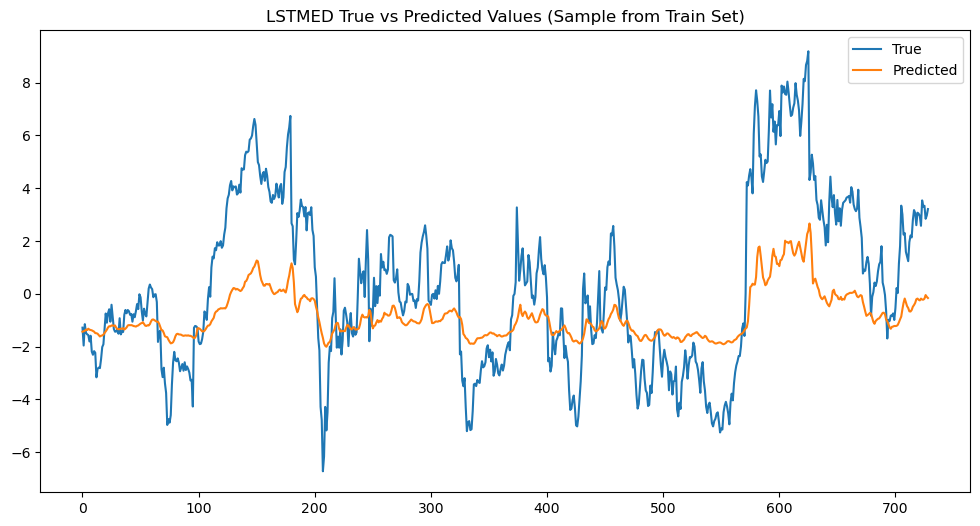

In [2]:
evaluation_results = []

for pair in valid_pairs:

    evaluation_dict = {}
    
    # Compute spread

    ticker_1 = pair[0]
    ticker_2 = pair[1]

    evaluation_dict["Name"] = f'{ticker_1} and {ticker_2}'

    ticker_series_1 = df[ticker_1]
    ticker_series_2 = df[ticker_2]

    slope, intercept, _, _, _ = linregress(ticker_series_1, ticker_series_2)
    spread = ticker_series_2 - (slope * ticker_series_1 + intercept)

    data = spread.values

    # Normalize data, split train and test, create sequences and reshpae them for model

    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

    def create_sequences(data, input_length, output_length):
        X, y = [], []
        for i in range(len(data) - input_length - output_length + 1):
            X.append(data[i:i + input_length])
            y.append(data[i + input_length:i + input_length + output_length])
        return np.array(X), np.array(y)

    input_length = 3
    output_length = 1

    train_size = int(len(data) * 0.8)
    train_data = data[:train_size]
    test_data = data[train_size:]

    X_train, y_train = create_sequences(train_data, input_length, output_length)
    X_test, y_test = create_sequences(test_data, input_length, output_length)

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

    # Construct LSTM Encoder Decoder model

    # Encoder
    
    inputs = Input(shape=(input_length, 1))
    encoder = LSTM(5, activation='relu', return_sequences=True)(inputs)
    encoder = Dropout(0.2)(encoder)
    encoder = LSTM(5, activation='relu')(encoder)
    encoder = Dropout(0.2)(encoder)
    encoder = RepeatVector(output_length)(encoder)

    # Decoder
    
    decoder = LSTM(5, activation='relu', return_sequences=True)(encoder)
    decoder = Dropout(0.2)(decoder)
    decoder = LSTM(5, activation='relu', return_sequences=True)(decoder)
    decoder = Dropout(0.2)(decoder)
    outputs = TimeDistributed(Dense(1))(decoder)

    # Model
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    model.summary()

    # Callbacks

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=5, batch_size=16, validation_split=0.2, callbacks=[early_stopping])


    test_loss = model.evaluate(X_test, y_test)
    evaluation_dict["LSTMED Test Loss"] = test_loss

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('LSTMED Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/lstmed_loss_plot.png')
    plt.close()

    # Make predictions and compute trend on training data

    predicted_train = model.predict(X_train)
    predicted_train = scaler.inverse_transform(predicted_train.reshape(-1, 1)).reshape(predicted_train.shape)
    y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)

    y_train_true_trend = []
    for i in range(1, len(y_train_true)):
        if np.mean(y_train_true[i,:]) > np.mean(y_train_true[i-1,:]):
            y_train_true_trend.append(1)
        elif np.mean(y_train_true[i,:]) < np.mean(y_train_true[i-1,:]):
            y_train_true_trend.append(-1)
        else:
            y_train_true_trend.append(0)

    predicted_train_trend = []
    for i in range(1, len(predicted_train)):
        if np.mean(predicted_train[i,:]) > np.mean(predicted_train[i-1,:]):
            predicted_train_trend.append(1)
        elif np.mean(predicted_train[i,:]) < np.mean(predicted_train[i-1,:]):
            predicted_train_trend.append(-1)
        else:
            predicted_train_trend.append(0)

    # Make predictions and compute trend on test data

    predicted_test = model.predict(X_test)
    predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1)).reshape(predicted_test.shape)
    y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

    y_test_true_trend = []
    for i in range(1, len(y_test_true)):
        if np.mean(y_test_true[i,:]) > np.mean(y_test_true[i-1,:]):
            y_test_true_trend.append(1)
        elif np.mean(y_test_true[i,:]) < np.mean(y_test_true[i-1,:]):
            y_test_true_trend.append(-1)
        else:
            y_test_true_trend.append(0)

    predicted_test_trend = []
    for i in range(1, len(predicted_test)):
        if np.mean(predicted_test[i,:]) > np.mean(predicted_test[i-1,:]):
            predicted_test_trend.append(1)
        elif np.mean(predicted_test[i,:]) < np.mean(predicted_test[i-1,:]):
            predicted_test_trend.append(-1)
        else:
            predicted_test_trend.append(0)

    # Plot the results of the model

    plt.figure(figsize=(12, 6))
    plt.plot(y_train_true[:,0], label='True')
    plt.plot(predicted_train[:,0], label='Predicted')
    plt.title('LSTMED True vs Predicted Values (Sample from Train Set)')
    plt.legend()
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/lstmed_train_predictions_plot.png')
    plt.close()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_true[:,0], label='True')
    plt.plot(predicted_test[:,0], label='Predicted')
    plt.title('LSTMED True vs Predicted Values (Sample from Test Set)')
    plt.legend()
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/lstmed_test_predictions_plot.png')
    plt.close()

    # Compute trend accuracy for test & train set, plot computed trends

    accuracy_trend_train = [y_train_true_trend[i] == predicted_train_trend[i] for i in range(len(predicted_train_trend))]
    accuracy_trend_test = [y_test_true_trend[i] == predicted_test_trend[i] for i in range(len(predicted_test_trend))]

    evaluation_dict["LSTMED Train Trend Accuracy"] = np.sum(accuracy_trend_train)/len(accuracy_trend_train)
    evaluation_dict["LSTMED Test Trend Accuracy"] = np.sum(accuracy_trend_test)/len(accuracy_trend_test)

    plt.figure(figsize=(12, 6))
    for i in range(len(y_test_true_trend)):
        if y_test_true_trend[i] == predicted_test_trend[i]:
            plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='g')
        elif y_test_true_trend[i] > predicted_test_trend[i]:
            plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='r')
        else:
            plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='b')
    red_patch = mpatches.Patch(color='red', label='Predicted Downwards Trend, True Upwards Trend')
    green_patch = mpatches.Patch(color='green', label='Correct Prediction')
    blue_patch = mpatches.Patch(color='blue', label='Predicted Upwards Trend, True Downwards Trend')
    plt.ylim(-5,5)
    plt.title('LSTMED True vs Predicted Trend Diff (Sample from Test Set)')
    plt.legend(handles=[red_patch, green_patch, blue_patch])
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/lstmed_test_trend_diff_plot.png')
    plt.close()

    # Smooth out signal by computing Moving Averages

    y_test_true_ma_adjusted = [np.mean(y_test_true[i,:]) for i in range(len(y_test_true))]
    predicted_test_ma_adjusted = [np.mean(predicted_test[i,:,:]) for i in range(len(predicted_test))]

    y_train_true_ma_adjusted = [np.mean(y_train_true[i,:]) for i in range(len(y_train_true))]
    predicted_train_ma_adjusted = [np.mean(predicted_train[i,:,:]) for i in range(len(predicted_train))]

    # Plot MAs

    plt.figure(figsize=(12, 6))
    plt.plot(y_test_true_ma_adjusted, label='True MA')
    plt.plot(predicted_test_ma_adjusted, label='Predicted MA')
    plt.title('LSTMED True vs Predicted MAs (Sample from Test Set)')
    plt.legend()
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/lstmed_test_predictions_ma_plot.png')
    plt.close()

    plt.figure(figsize=(12, 6))
    plt.plot(y_train_true_ma_adjusted, label='True MA')
    plt.plot(predicted_train_ma_adjusted, label='Predicted MA')
    plt.title('LSTMED True vs Predicted MAs (Sample from Train Set)')
    plt.legend()
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/lstmed_train_predictions_ma_plot.png')
    plt.close()

    # Create lagged features

    def create_lagged_features(series, lags=5):
        spread = pd.Series(series, name='spread')
        df = pd.DataFrame(spread)
        for lag in range(1, lags + 1):
            df[f'lag_{lag}'] = df['spread'].shift(lag)
        df.dropna(inplace=True)
        return df

    lags = 5
    lagged_df = create_lagged_features(data, lags=lags)

    # Split into train and test sets

    X = lagged_df.drop(columns=['spread'])
    y = lagged_df['spread']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Train and predict with Random Forest Regressor

    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)

    # Train and predict with XGBoost

    xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
    xgb_model.fit(X_train, y_train)
    xgb_predictions = xgb_model.predict(X_test)

    # Evaluate Random Forest

    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_mae = mean_absolute_error(y_test, rf_predictions)
    evaluation_dict["Random Forest MSE"] = rf_mse
    evaluation_dict["Random Forest MAE"] = rf_mae

    # Evaluate XGBoost

    xgb_mse = mean_squared_error(y_test, xgb_predictions)
    xgb_mae = mean_absolute_error(y_test, xgb_predictions)
    evaluation_dict["XGBoost MSE"] = xgb_mse
    evaluation_dict["XGBoost MAE"] = xgb_mae

    # Example: Plot the results

    plt.figure(figsize=(15, 6))
    plt.title('Random Forest and XGBoost Predictions')
    plt.plot(y_test.index, y_test, label='True Values', color='blue')
    plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', color='green')
    plt.plot(y_test.index, xgb_predictions, label='XGBoost Predictions', color='red')
    plt.legend()
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/spread_forecasting_rf_xgb_predictions_plot.png')
    plt.close()

    # Random Forest Directional Accuracy

    trend_rf = []
    for i in range(1, len(y_test)-10):
        if rf_predictions[i] > y_test.iloc[i-1]:
            trend_rf.append(1)
        elif rf_predictions[i] < y_test.iloc[i-1]:
            trend_rf.append(-1)
        else:
            trend_rf.append(0)

    trend_rf_true = []
    for i in range(1, len(y_test)-10):
        if np.mean(y_test.iloc[i:i+10]) > y_test.iloc[i-1]:
            trend_rf_true.append(1)
        elif np.mean(y_test.iloc[i:i+10]) < y_test.iloc[i-1]:
            trend_rf_true.append(-1)
        else:
            trend_rf_true.append(0)

    accuracy_trend = [trend_rf[i] == trend_rf_true[i] for i in range(len(trend_rf))] 
    evaluation_dict["Random Forest Trend Accuracy"] = np.sum(accuracy_trend)/len(accuracy_trend)

    # XGBoost Directional Accuracy

    trend_xgb = []
    for i in range(1, len(y_test)-10):
        if xgb_predictions[i] > y_test.iloc[i-1]:
            trend_xgb.append(1)
        elif xgb_predictions[i] < y_test.iloc[i-1]:
            trend_xgb.append(-1)
        else:
            trend_xgb.append(0)

    trend_xgb_true = []
    for i in range(1, len(y_test)-10):
        if np.mean(y_test.iloc[i:i+10]) > y_test.iloc[i-1]:
            trend_xgb_true.append(1)
        elif np.mean(y_test.iloc[i:i+10]) < y_test.iloc[i-1]:
            trend_xgb_true.append(-1)
        else:
            trend_xgb_true.append(0)

    accuracy_trend = [trend_xgb[i] == trend_xgb_true[i] for i in range(len(trend_xgb))] 
    evaluation_dict["XGBoost Trend Accuracy"] = np.sum(accuracy_trend)/len(accuracy_trend)

    prophet_df = pd.DataFrame({'ds': pd.to_datetime(ticker_series_1.index), 'y': spread})
    for lag in range(1, 11):
        prophet_df[f'lag_{lag}'] = prophet_df['y'].shift(lag)
    prophet_df.dropna(inplace=True)

    # Prepare the data

    prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)

    train_size = int(len(prophet_df) * 0.8)
    train_prophet_df = prophet_df.iloc[:train_size]
    test_prophet_df = prophet_df.iloc[train_size:]
    
    # Initialize and fit the model
    
    prophet_model = Prophet()
    prophet_model.fit(train_prophet_df)

    # Make predictions

    forecast = prophet_model.predict(test_prophet_df)

    # Show forecast and components

    fig = prophet_model.plot_components(forecast)
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/prophet_components_plot.png')
    plt.close()

    f, ax = plt.subplots(figsize=(15, 5))
    ax.scatter(test_prophet_df['ds'], test_prophet_df['y'], color='r')
    fig = prophet_model.plot(forecast, ax=ax)
    plt.savefig(f'../../assets/stocks/{ticker_1}_{ticker_2}/prophet_predictions_plot.png')
    plt.close()

    # Evaluate the model
    
    evaluation_dict["Prophet MSE"] = mean_squared_error(y_true=test_prophet_df['y'],
                    y_pred=forecast['yhat'])
    evaluation_dict["Prophet MAE"] = mean_absolute_error(y_true=test_prophet_df['y'],
                    y_pred=forecast['yhat'])
    
    evaluation_results.append(evaluation_dict)

evaluation_results_df = pd.DataFrame(evaluation_results)
evaluation_results_df.to_csv('../../assets/stocks/spread_forecasting_models_evaluation_results.csv', index=False)

In [3]:
print(evaluation_results_df)
evaluation_results_df.info()
evaluation_results_df.describe()

NameError: name 'evaluation_results_df' is not defined

# Forecasting spread and determining trend

Pairs trading requires us to model the returns of a pair of assets. Traditional methods use linear regression to establish a linear relationship between the price series of a pair of assets. Unfortunately, machine learning proves to be a difficult approach to model this relationship.

### Why do we use a linear model?
1. An OLS estimator establishes a linear relationship between the assets solely based on price series. Machine learning applications require extra features and more information regarding the price series individually. This makes it difficult to focus on the spread using machine learning applications. A counter-approach to this problem would be making predictions on the price series individually, which would require extensive research into the factors affecting prices of assets and would surpass the scope of the research question at hand.
2. Our pair selection criteria specifically assumes a mean-reverting, stationary and homoskedastic linear combination of the two price series. By definition, our spread is based on a linear relationship between the two price series. Selecting the pair based on a linear model, then establishing the relationship using a non-linear model would be a faulty approach.

### How do we apply machine learning?
Despite settling on a linear model, there are still areas of exploration for machine learning such as setting the thresholds for trade execution and more importantly predicting the trend of the spread to maximize profits. Predicting the trend of the spread would allow us to take positions with the highest ROI instead of relying on a static threshold. The rest of this document focuses on forecasting the spread to be able to "sell the peak and buy the dip".

### Trend over static thresholds

There are two benefits of relying on trend over static thresholds:
1. We can execute smaller trades even if the spread does not cross the upper or lower threshold.
2. Even if the spread crosses the threshold, we can wait for the trend reversion to execute trades. This would allow us to "hold" until the optimal moment.

### Example

Assume the spread has a mean of 0 and we set our upper and lower thresholds to take positions at 1 and -1 respectively. We "short" the spread when the spread crosses 1 and "long" the spread when it crosses -1. We close positions whenever the spread reverts back to the mean. Imagine a case where we have the following time series for the spread:

| t0 | t1 | t2 | t3 | t4 | t5 | t6 | t7 | t8 |
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
| 0 | 1 | 2 | 3 | 1 | 0 | -1 | -2 | 0 |

1. We "short" the spread at t1 and close the short position at t5 when it reverts back to its mean of 0, resulting in a profit of 1.
2. We "long" the spread at t6 and close the long position at t8 when it reverts back to its mean of 0, resulting in another profit of 1.

**Our total profit is 2.**

Now imagine a case where we predicted the trend changes correctly, that is when the gradient of the price series crosses 0. In simpler terms, when the price series stops going up and starts going down or vice versa. These trend changes occur at t4 and t8 respectively. If we could predict these changes at t3 and t7:
1. We "short" the spread at t3 and close the short position at t5 when it reverts back to its mean of 0, resulting in a profit of 3.
2. We "long" the spread at t7 and close the long position at t8 when it reverts back to its mean of 0, resulting in another profit of 2.

**Our total profit is 5.**

Of course stochastic processes are much more complicated in practice, but the general principle holds.

Imagine another case where the price series oscillates around 0 and between 0.5 and -0.5. Relying on the thresholds, we wouldn't execute any trades resulting in a profit of 0. On the other hand, if we rely on trend changing direction, we would be execute trades at every oscillation resulting in a net positive profit.

One drawback of this approach is that it still does not help with the cases where the spread does not cross its own mean before the next trend change. This is also an issue we will run into while dealing with static tresholds. Another drawback is that predicting the future, especially in financial markets, is **very** difficult :)

# Computing spread

We start by computing the spread based on the price series of the two tickers. We achieve this by fitting the two price series into a linear regression model, the error terms are essentially the spread of our model.

In [5]:
# Compute spread

ticker_1 = valid_pairs[0][0]
ticker_2 = valid_pairs[0][1]

ticker_series_1 = df[ticker_1]
ticker_series_2 = df[ticker_2]
print(ticker_series_1)

slope, intercept, _, _, _ = linregress(ticker_series_1, ticker_series_2)
spread = ticker_series_2 - (slope * ticker_series_1 + intercept)

data = spread.values
print(data)

Timestamp
2019-05-15 04:00:00+00:00    44.01
2019-05-16 04:00:00+00:00    44.49
2019-05-17 04:00:00+00:00    43.39
2019-05-20 04:00:00+00:00    43.08
2019-05-21 04:00:00+00:00    43.93
                             ...  
2022-12-23 05:00:00+00:00    41.74
2022-12-27 05:00:00+00:00    41.34
2022-12-28 05:00:00+00:00    40.33
2022-12-29 05:00:00+00:00    41.66
2022-12-30 05:00:00+00:00    41.58
Name: AVT, Length: 916, dtype: float64
[-1.95373960e+00 -1.85482092e+00 -2.01067623e+00 -1.27914455e+00
 -1.95689272e+00 -1.14815352e+00 -1.47409913e+00 -1.53265774e+00
 -1.56112605e+00 -1.80328814e+00 -1.58572056e+00 -2.18743173e+00
 -2.30653100e+00 -2.16977495e+00 -2.23121634e+00 -3.16031561e+00
 -2.83950517e+00 -2.78941543e+00 -2.81166781e+00 -2.46698301e+00
 -2.01382990e+00 -1.91139693e+00 -1.33346872e+00 -7.44099677e-01
 -1.09148722e+00 -7.29054805e-01 -5.82297662e-01 -1.05373905e+00
 -4.12567992e-01 -8.50496197e-01 -1.33049675e+00 -1.43157806e+00
 -1.42896561e+00 -1.34310920e+00 -1.50788429e+

# LSTM Encoder Decoder Model Data Preparation

LSTM Encoder Decoder models use a sequence of time series data to project a sequence of forecasted time series. The input length determines the length of the sequence used for prediction and the output length defines how many time periods to predict into the future. We also split our dataset into test and train sets to dodge look-ahead bias and then reshape the data into the format required for the model.

In [6]:
# Normalize data, split train and test, create sequences and reshpae them for model

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

def create_sequences(data, input_length, output_length):
    X, y = [], []
    for i in range(len(data) - input_length - output_length + 1):
        X.append(data[i:i + input_length])
        y.append(data[i + input_length:i + input_length + output_length])
    return np.array(X), np.array(y)

input_length = 90
output_length = 3

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

X_train, y_train = create_sequences(train_data, input_length, output_length)
X_test, y_test = create_sequences(test_data, input_length, output_length)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], 1))

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], 1))

# Constructing the Model

We construct encoder and decoder cells by utilizing LSTM and dropout layers. LSTM layers produce a set of units / nodes for prediction and the Dropout layers ensure that a certain portion of units are unweighed at each step to prevent overfitting. The encoder then produces a repeat vector for the decoder to process, and the decoder produces the expected output sequence with one feature per time step thanks to the Dense layer. We also utilize an early stopping callback to stop training if there is no meaningful loss following a set number of steps. We plot the training loss and save model evaluation metrics.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 90, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 90, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 90, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 3, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 3, 50)          │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 3, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 3, 1)           │            51 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,051 (277.54 KB)

 Trainable params: 71,051 (277.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.1689 - val_loss: 0.1000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0548 - val_loss: 0.0873
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0423 - val_loss: 0.0215
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0369 - val_loss: 0.0207
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0227 - val_loss: 0.0196
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0221 - val_loss: 0.0126
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0210 - val_loss: 0.0171
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0163 - val_loss: 0.0130
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0158 - val_loss: 0.0166
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0165 - val_loss: 0.0110
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0153 - val_loss: 0.0143
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0

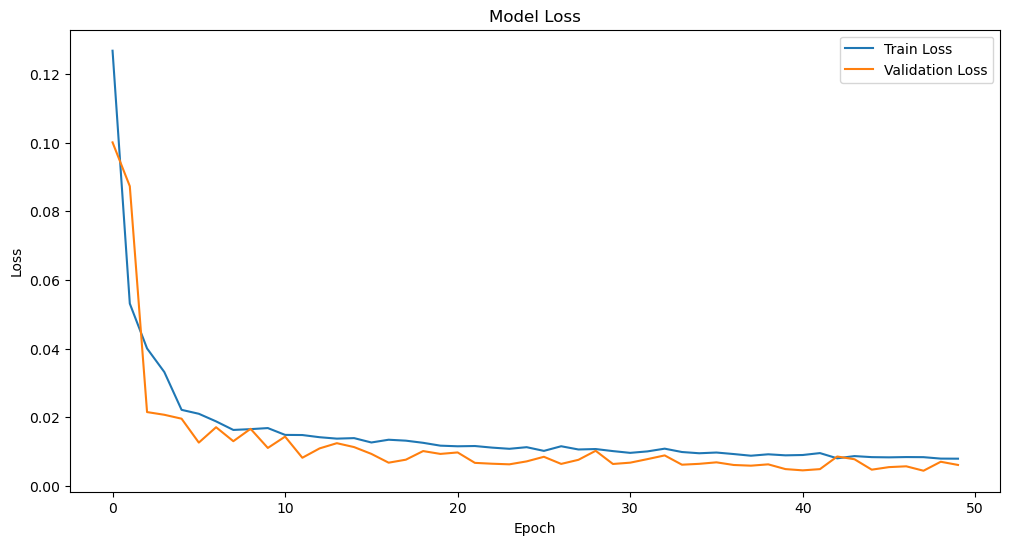

In [7]:
# Construct LSTM Encoder Decoder model

# Encoder

inputs = Input(shape=(input_length, 1))
encoder = LSTM(50, activation='relu', return_sequences=True)(inputs)
encoder = Dropout(0.2)(encoder)
encoder = LSTM(50, activation='relu')(encoder)
encoder = Dropout(0.2)(encoder)
encoder = RepeatVector(output_length)(encoder)

# Decoder

decoder = LSTM(50, activation='relu', return_sequences=True)(encoder)
decoder = Dropout(0.2)(decoder)
decoder = LSTM(50, activation='relu', return_sequences=True)(decoder)
decoder = Dropout(0.2)(decoder)
outputs = TimeDistributed(Dense(1))(decoder)

# Model

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

# Callbacks

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])


test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluating Predictions

We make predictions on both the train and test set and compute trend on both the actual values and the predictions. We define trend to be the comparison of the mean of last **n** values in the time series to the next **n** values predicted by the model, where **n** refers to the output length of the model.

We plot actual values vs. predictions as well as moving averages of actual values vs. moving averages of predictions to demonstrate trend. We then compute the directional accuracy of the trend.

In [8]:
# Make predictions and compute trend on training data

predicted_train = model.predict(X_train)
print(len(predicted_train))
print(len(X_train))
predicted_train = scaler.inverse_transform(predicted_train.reshape(-1, 1)).reshape(predicted_train.shape)
y_train_true = scaler.inverse_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)

y_train_true_trend = []
for i in range(1, len(y_train_true)):
    if np.mean(y_train_true[i,:]) > np.mean(y_train_true[i-1,:]):
        y_train_true_trend.append(1)
    elif np.mean(y_train_true[i,:]) < np.mean(y_train_true[i-1,:]):
        y_train_true_trend.append(-1)
    else:
        y_train_true_trend.append(0)

predicted_train_trend = []
for i in range(1, len(predicted_train)):
    if np.mean(predicted_train[i,:]) > np.mean(predicted_train[i-1,:]):
        predicted_train_trend.append(1)
    elif np.mean(predicted_train[i,:]) < np.mean(predicted_train[i-1,:]):
        predicted_train_trend.append(-1)
    else:
        predicted_train_trend.append(0)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
640
640


In [9]:
# Make predictions and compute trend on test data

predicted_test = model.predict(X_test)
predicted_test = scaler.inverse_transform(predicted_test.reshape(-1, 1)).reshape(predicted_test.shape)
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

y_test_true_trend = []
for i in range(1, len(y_test_true)):
    if np.mean(y_test_true[i,:]) > np.mean(y_test_true[i-1,:]):
        y_test_true_trend.append(1)
    elif np.mean(y_test_true[i,:]) < np.mean(y_test_true[i-1,:]):
        y_test_true_trend.append(-1)
    else:
        y_test_true_trend.append(0)

predicted_test_trend = []
for i in range(1, len(predicted_test)):
    if np.mean(predicted_test[i,:]) > np.mean(predicted_test[i-1,:]):
        predicted_test_trend.append(1)
    elif np.mean(predicted_test[i,:]) < np.mean(predicted_test[i-1,:]):
        predicted_test_trend.append(-1)
    else:
        predicted_test_trend.append(0)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


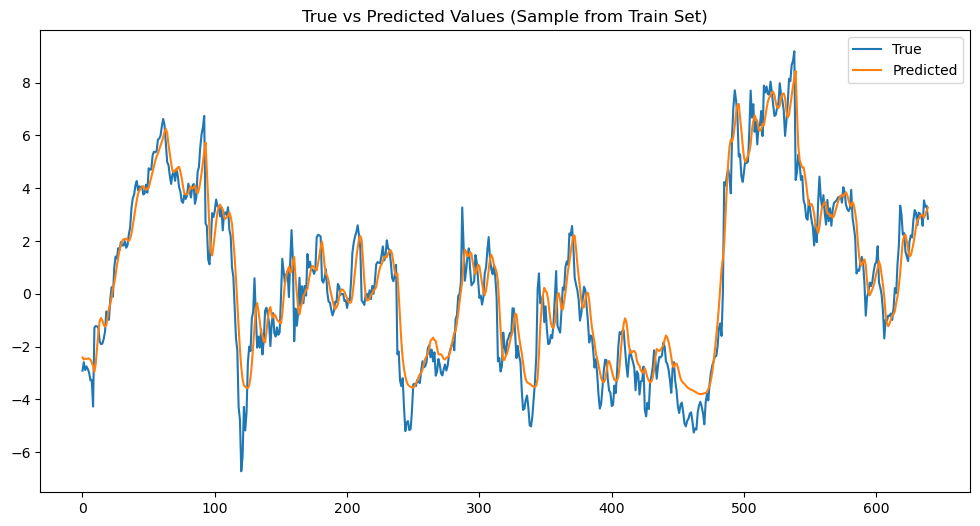

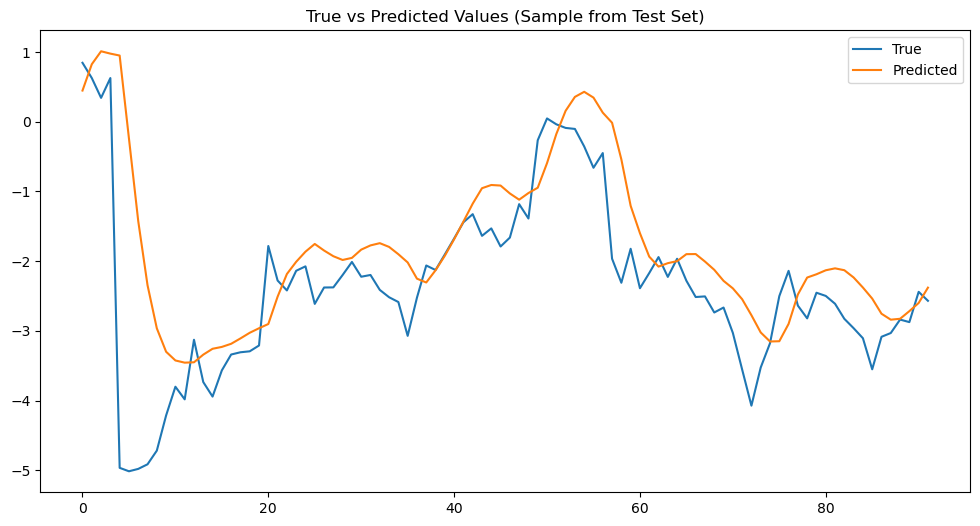

In [10]:
# Plot the results of the model

plt.figure(figsize=(12, 6))
plt.plot(y_train_true[:,0], label='True')
plt.plot(predicted_train[:,0], label='Predicted')
plt.title('True vs Predicted Values (Sample from Train Set)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test_true[:,0], label='True')
plt.plot(predicted_test[:,0], label='Predicted')
plt.title('True vs Predicted Values (Sample from Test Set)')
plt.legend()
plt.show()

0.486697965571205
0.43956043956043955


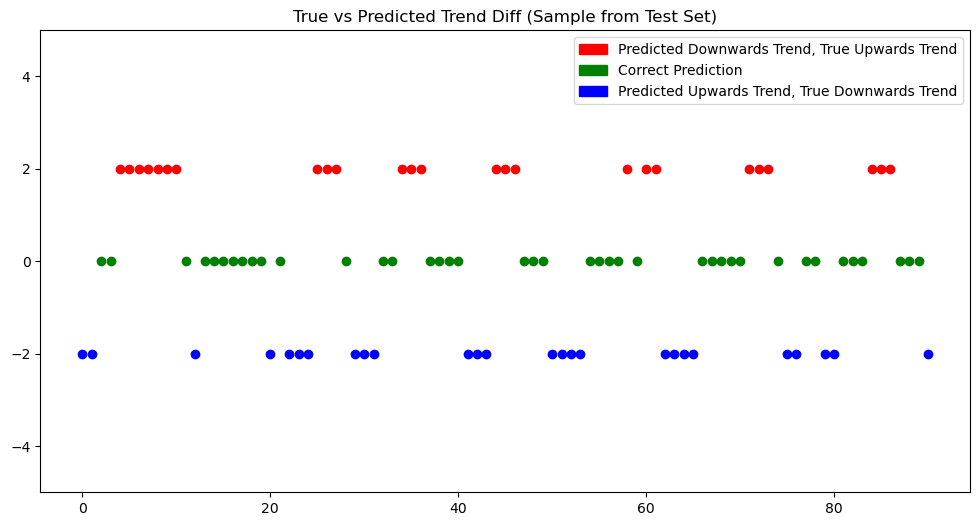

In [11]:
# Compute trend accuracy for test & train set, plot computed trends

accuracy_trend_train = [y_train_true_trend[i] == predicted_train_trend[i] for i in range(len(predicted_train_trend))]
accuracy_trend_test = [y_test_true_trend[i] == predicted_test_trend[i] for i in range(len(predicted_test_trend))]
print(np.sum(accuracy_trend_train)/len(accuracy_trend_train))
print(np.sum(accuracy_trend_test)/len(accuracy_trend_test))

plt.figure(figsize=(12, 6))
for i in range(len(y_test_true_trend)):
  if y_test_true_trend[i] == predicted_test_trend[i]:
    plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='g')
  elif y_test_true_trend[i] > predicted_test_trend[i]:
    plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='r')
  else:
    plt.scatter(i, y_test_true_trend[i] - predicted_test_trend[i], c='b')
red_patch = mpatches.Patch(color='red', label='Predicted Downwards Trend, True Upwards Trend')
green_patch = mpatches.Patch(color='green', label='Correct Prediction')
blue_patch = mpatches.Patch(color='blue', label='Predicted Upwards Trend, True Downwards Trend')
plt.ylim(-5,5)
plt.title('True vs Predicted Trend Diff (Sample from Test Set)')
plt.legend(handles=[red_patch, green_patch, blue_patch])
plt.show()

In [12]:
# Smooth out signal by computing Moving Averages

y_test_true_ma_adjusted = [np.mean(y_test_true[i,:]) for i in range(len(y_test_true))]
predicted_test_ma_adjusted = [np.mean(predicted_test[i,:,:]) for i in range(len(predicted_test))]

y_train_true_ma_adjusted = [np.mean(y_train_true[i,:]) for i in range(len(y_train_true))]
predicted_train_ma_adjusted = [np.mean(predicted_train[i,:,:]) for i in range(len(predicted_train))]

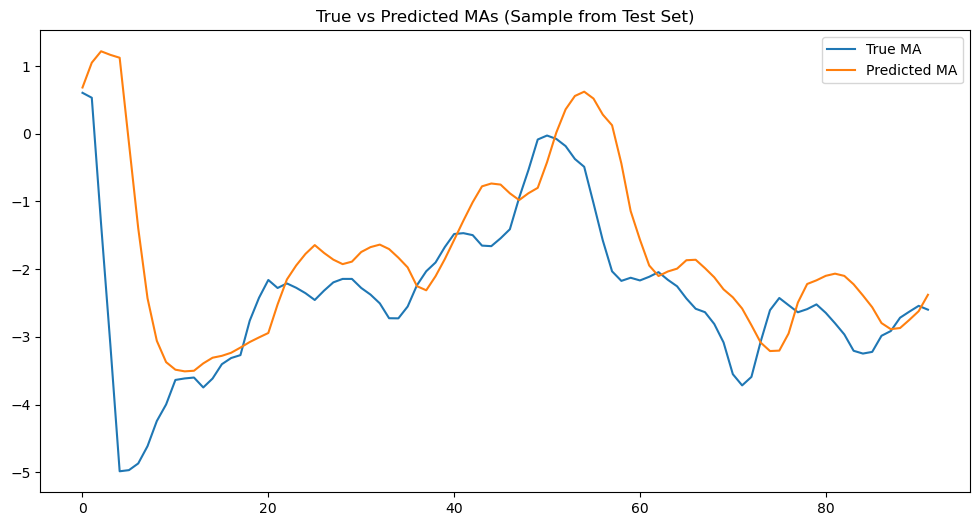

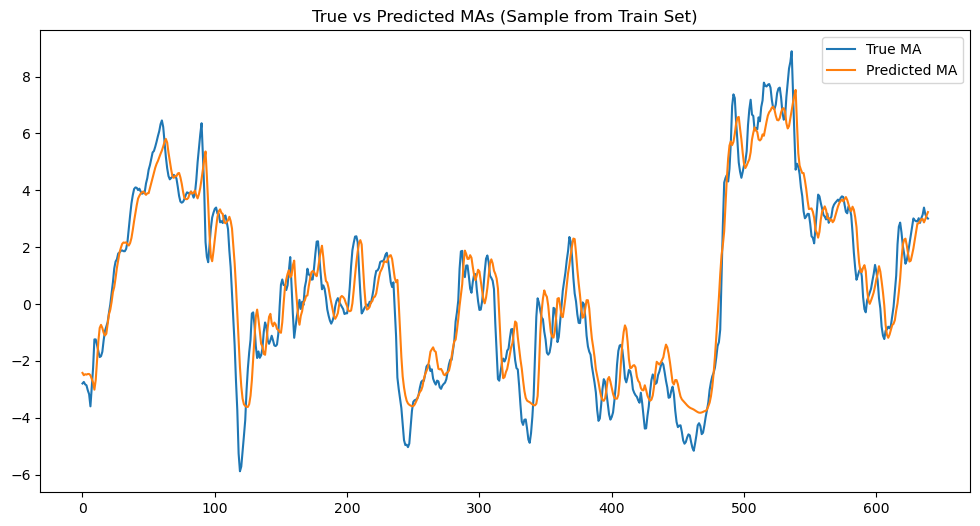

In [13]:
# Plot MAs

plt.figure(figsize=(12, 6))
plt.plot(y_test_true_ma_adjusted, label='True MA')
plt.plot(predicted_test_ma_adjusted, label='Predicted MA')
plt.title('True vs Predicted MAs (Sample from Test Set)')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_train_true_ma_adjusted, label='True MA')
plt.plot(predicted_train_ma_adjusted, label='Predicted MA')
plt.title('True vs Predicted MAs (Sample from Train Set)')
plt.legend()
plt.show()

# Random Forest and XGBoost Regressors Data Preparation

After the LSTM Encoder Decoder Model that leverages neural networks, we test the same assumptions under two oter popular methods in time series forecasting: tree-based models and gradient boosting methods. To test these approaches, we rely on existing literature for time series prediction and construct a Random Forest Regressor and XGBoost model. These models do not work with time series data out of the box, therefore we reconstruct our input to contain the previous 5 data points for each point in the dataset as features. The labels are the actual values. Again, we use a train test split to evaluate results.

| Day | lag_5 | lag_4 | lag_3 | lag_2 | lag_1 | current |
|--|--|--|--|--|--|--|
|1|10|11|13|12|14|16|
|2|11|13|12|14|16|17|
|3|13|12|14|16|17|15|

.\
.\
.

In [14]:
# Create lagged features

def create_lagged_features(series, lags=5):
    spread = pd.Series(series, name='spread')
    df = pd.DataFrame(spread)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['spread'].shift(lag)
    df.dropna(inplace=True)
    return df

lags = 5
lagged_df = create_lagged_features(data, lags=lags)

# Split into train and test sets

X = lagged_df.drop(columns=['spread'])
y = lagged_df['spread']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Train and predict with Random Forest Regressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Train and predict with XGBoost

xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)


# Evaluation of the Models

We compute the RMSEs and MAEs of both models and save them. We plot the predictions against the actual values first, then compute trend and calculate the directional accuracy. We store all results in our evaluation results dictionary.

Random Forest MAE: 0.02999768374964058
XGBoost MAE: 0.03395957586268747


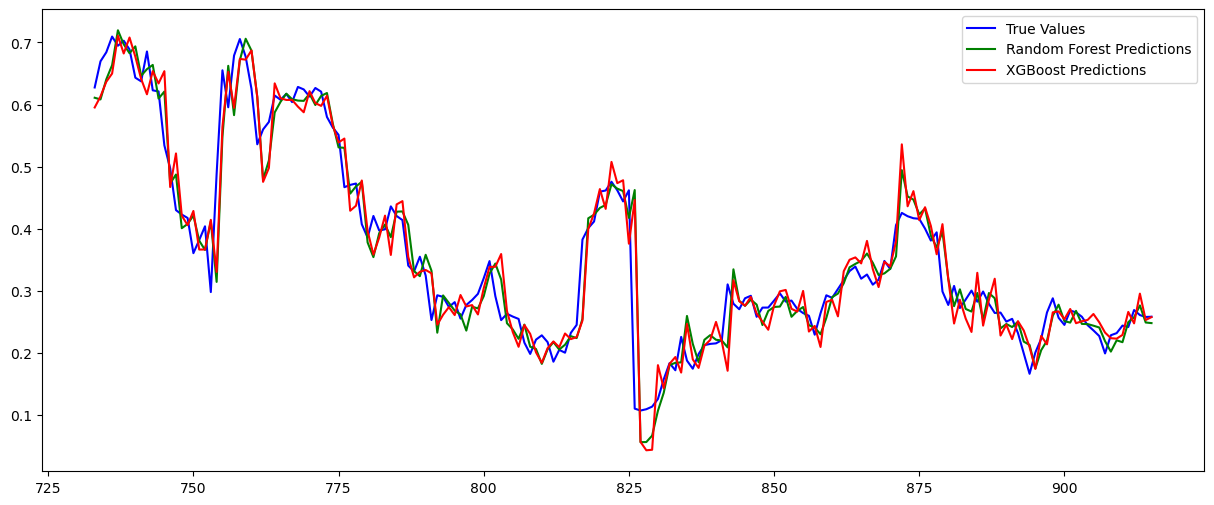

In [15]:
# Evaluate Random Forest

rf_mae = mean_absolute_error(y_test, rf_predictions)
print(f'Random Forest MAE: {rf_mae}')

# Evaluate XGBoost

xgb_mae = mean_absolute_error(y_test, xgb_predictions)
print(f'XGBoost MAE: {xgb_mae}')

# Example: Plot the results

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(y_test.index, y_test, label='True Values', color='blue')
plt.plot(y_test.index, rf_predictions, label='Random Forest Predictions', color='green')
plt.plot(y_test.index, xgb_predictions, label='XGBoost Predictions', color='red')
plt.legend()
plt.show()


In [16]:
# Random Forest Directional Accuracy

trend_rf = []
for i in range(1, len(y_test)-10):
    if rf_predictions[i] > y_test.iloc[i-1]:
        trend_rf.append(1)
    elif rf_predictions[i] < y_test.iloc[i-1]:
        trend_rf.append(-1)
    else:
        trend_rf.append(0)

trend_rf_true = []
for i in range(1, len(y_test)-10):
    if np.mean(y_test.iloc[i:i+10]) > y_test.iloc[i-1]:
        trend_rf_true.append(1)
    elif np.mean(y_test.iloc[i:i+10]) < y_test.iloc[i-1]:
        trend_rf_true.append(-1)
    else:
        trend_rf_true.append(0)

accuracy_trend = [trend_rf[i] == trend_rf_true[i] for i in range(len(trend_rf))] 
print(np.sum(accuracy_trend)/len(accuracy_trend))


0.6337209302325582


In [17]:
# XGBoost Directional Accuracy

trend_xgb = []
for i in range(1, len(y_test)-10):
    if xgb_predictions[i] > y_test.iloc[i-1]:
        trend_xgb.append(1)
    elif xgb_predictions[i] < y_test.iloc[i-1]:
        trend_xgb.append(-1)
    else:
        trend_xgb.append(0)

trend_xgb_true = []
for i in range(1, len(y_test)-10):
    if np.mean(y_test.iloc[i:i+10]) > y_test.iloc[i-1]:
        trend_xgb_true.append(1)
    elif np.mean(y_test.iloc[i:i+10]) < y_test.iloc[i-1]:
        trend_xgb_true.append(-1)
    else:
        trend_xgb_true.append(0)

accuracy_trend = [trend_xgb[i] == trend_xgb_true[i] for i in range(len(trend_xgb))] 
print(np.sum(accuracy_trend)/len(accuracy_trend))


0.622093023255814


# Prophet Model

Lastly, as a wildcard choice, we test Meta's Prophet model which is heavily utilized in time series forecasting. The catch is that Prophet is mainly popular for time series data with seasonality. We can't assume our spread to be stochastically seasonal but it would be a fair hypothesis to expect oscillations around the mean. Although not the same as seasonality, this implies mildly similar stochastical characteristics. In addition, Prophet provides upper and lower bounds for predictions, trend lines and even changepoints for trend as part of the model, which may prove useful in our study.

Unfortunately computing the accuracy of the model leads us to discard this option completely as the prediction accuracy is too low to produce reliable indicators of trend. In hindsight, this is to be expected since our data has no seasonal characteristics and no extra information other than the past values of the time series. The model struggles with establishing a causal relationship between the features and the trend or seasonal patterns. Nonetheless we compute accuracy metrics, plot components and trend, and save results.

                                           ds         y     lag_1     lag_2  \
Timestamp                                                                     
2019-05-30 04:00:00+00:00 2019-05-30 04:00:00 -1.585721 -1.803288 -1.561126   
2019-05-31 04:00:00+00:00 2019-05-31 04:00:00 -2.187432 -1.585721 -1.803288   
2019-06-03 04:00:00+00:00 2019-06-03 04:00:00 -2.306531 -2.187432 -1.585721   
2019-06-04 04:00:00+00:00 2019-06-04 04:00:00 -2.169775 -2.306531 -2.187432   
2019-06-05 04:00:00+00:00 2019-06-05 04:00:00 -2.231216 -2.169775 -2.306531   

                              lag_3     lag_4     lag_5     lag_6     lag_7  \
Timestamp                                                                     
2019-05-30 04:00:00+00:00 -1.532658 -1.474099 -1.148154 -1.956893 -1.279145   
2019-05-31 04:00:00+00:00 -1.561126 -1.532658 -1.474099 -1.148154 -1.956893   
2019-06-03 04:00:00+00:00 -1.803288 -1.561126 -1.532658 -1.474099 -1.148154   
2019-06-04 04:00:00+00:00 -1.585721 -1.803288 -1.56

00:04:56 - cmdstanpy - INFO - Chain [1] start processing
00:04:56 - cmdstanpy - INFO - Chain [1] done processing
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this

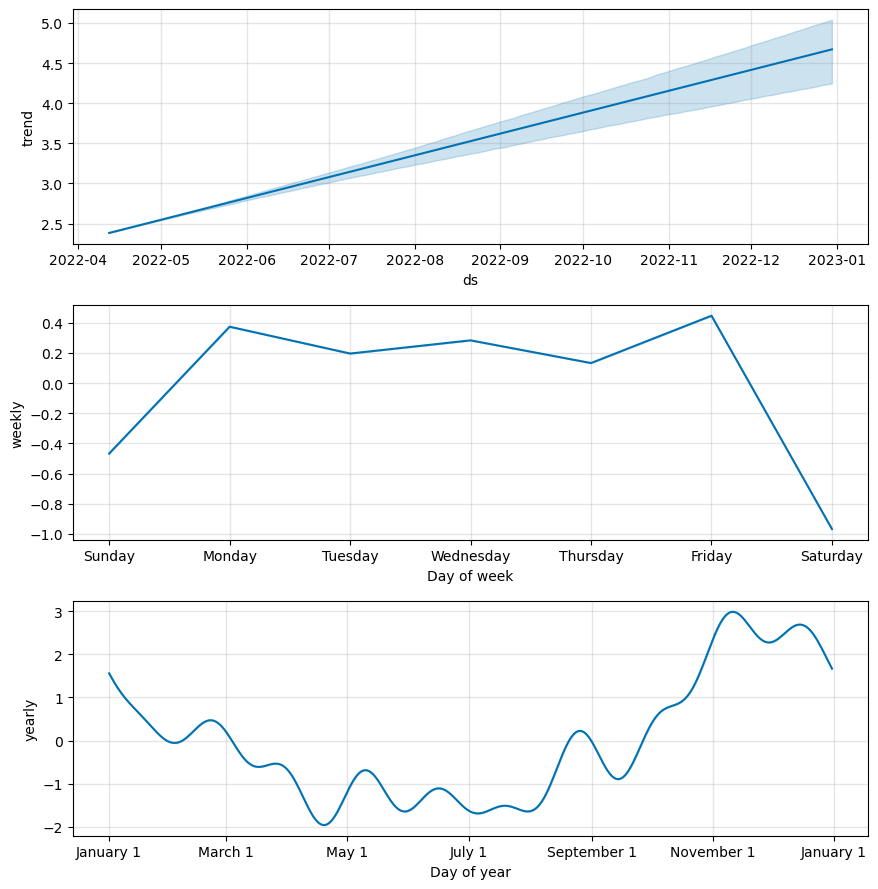

6.302199852892729
5.496320926250255


/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/anaconda3/lib/python3.12/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


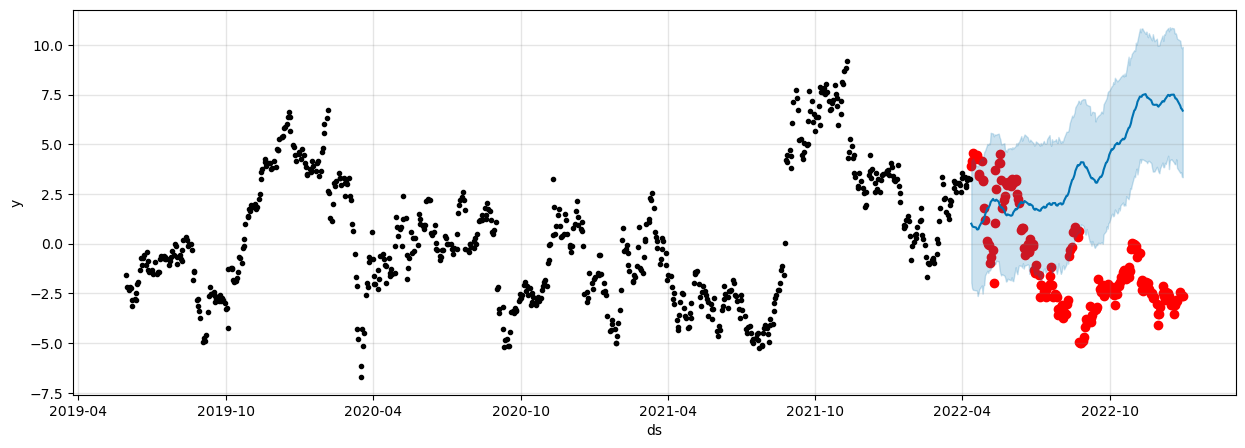

In [18]:
# Construct Prophet model

prophet_df = pd.DataFrame({'ds': pd.to_datetime(ticker_series_1.index), 'y': spread})
for lag in range(1, 11):
    prophet_df[f'lag_{lag}'] = prophet_df['y'].shift(lag)
prophet_df.dropna(inplace=True)

# Prepare the data

prophet_df['ds'] = prophet_df['ds'].dt.tz_localize(None)
print(prophet_df.head())

train_size = int(len(prophet_df) * 0.8)
train_prophet_df = prophet_df.iloc[:train_size]
test_prophet_df = prophet_df.iloc[train_size:]

# Initialize and fit the model

prophet_model = Prophet()
prophet_model.fit(train_prophet_df)

# Make future dataframe and predictions

forecast = prophet_model.predict(test_prophet_df)

# Show forecast

fig = prophet_model.plot_components(forecast)
plt.show()

f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_prophet_df['ds'], test_prophet_df['y'], color='r')
fig = prophet_model.plot(forecast, ax=ax)
print(np.sqrt(mean_squared_error(y_true=test_prophet_df['y'],
                   y_pred=forecast['yhat'])))

print(mean_absolute_error(y_true=test_prophet_df['y'],
                   y_pred=forecast['yhat']))
